# Using a New Machine Learning Classifier for Recipe Classiifer

Need to adapt all of this below. 
To add : 
- [DONE] calculate amount of fat
- [DONE]calculate % of macro nutrients (fat, carb, protein)
- [DONE] categories for balanced, hi-protein+hi_fat, hi_carb+hi_fat, lo_carb+high_protein, hi-carb+hi-protein
- find a python library to create feat engineering combining numeral feats togehther (multiplication, square, root, etc)
- [DONE]add a tool to compare b/w several models and recommend the best one 
- [DONE]add SHAP
- add neural network with regulation 
- [DONE]check if ok to use mean for imputing misisng value with skewed distribution - median is better in this case as macro nutrient distributions are skewed to the right.
- [DONE]check and resolve class imbalance




## Background

Choosing a machine learning model to use in a trading strategy is a matter of trial and error. In this way, you find a model that produces the desired outcomes with an acceptable level of performance.

In the machine learning section of the boot camp, you learned about some classification models, such as logistic regression, support vector machines (SVM), and neural networks. In this activity, you'll train a logistic regression model to make trading predictions, backtest the results, and then evaluate its performance compared to that of a SVM model.

## Methods:

1. Open the provided starter code. Inspect and run all the cells up to the “Add a New Machine Learning Model” section to review the data loading and preparation process, as well as the inclusion of a SVM model in a trading algorithm.

2. Import the `LogisticRegression` model from scikit-learn.

    > **Rewind** Recall that `LogisticRegression` models are used for binary classification problems.

3. Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

4. Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

5. Backtest the `LogisticRegression` model to evaluate its performance.

6. Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data.  Did the logistic regression model perform better than SVM? Write down your conclusions to share with the class.


## References

* [SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

* [SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

---

In [571]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

### Read the CSV file into Pandas DataFrame

In [572]:
# Import the OHLCV dataset into a Pandas Dataframe
recipe_df = pd.read_csv(
    Path("recipe_site_traffic_2212.csv"), 

)

# Review the DataFrame
recipe_df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


### Some Preprocessing
---

In [573]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [574]:
qc_recipe_df = recipe_df

# Replace all null values in column 'High_Traffic' with 0
qc_recipe_df['high_traffic'].fillna(0, inplace=True)

# Replace all 'High' values in column 'High_Traffic' with 1
qc_recipe_df['high_traffic'] = qc_recipe_df['high_traffic'].replace('High', 1)

qc_recipe_df.head()



,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,1
1,2,35.48,38.56,0.66,0.92,Potato,4,1
2,3,914.28,42.68,3.09,2.88,Breakfast,1,0
3,4,97.03,30.56,38.63,0.02,Beverages,4,1
4,5,27.05,1.85,0.80,0.53,Beverages,4,0


In [575]:
qc_recipe_df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [576]:
#replace "Lunch/Snacks" value in "category" column by "Lunch_Snacks" and replace spaces by "_" 
qc_recipe_df['category'] = qc_recipe_df['category'].replace('Lunch/Snacks', 'Lunch_Snacks')
qc_recipe_df['category'] = qc_recipe_df['category'].replace('One Dish Meal', 'One_Dish_Meal')
qc_recipe_df['category'] = qc_recipe_df['category'].replace('Chicken Breast', 'Chicken_Breast')

In [577]:
# check value of servings 
qc_recipe_df['servings'].unique()


array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

#### Understanding what "as a snack" means in the servings size

In [578]:
# let's understand what are the '6' servings and '6 as a snack' to understand better what '6 as a snack' means
serving6mean_df =  qc_recipe_df.loc[qc_recipe_df['servings']=='6'][['calories','carbohydrate','sugar','protein']].mean()
serving4mean_df =  qc_recipe_df.loc[qc_recipe_df['servings']=='4'][['calories','carbohydrate','sugar','protein']].mean()
serving6snack_df=  qc_recipe_df.loc[qc_recipe_df['servings']=='6 as a snack']
serving4snack_df=  qc_recipe_df.loc[qc_recipe_df['servings']=='4 as a snack']

In [579]:
pd.options.display.float_format = '{:,.2f}'.format
print(serving6mean_df)

calories       419.13
carbohydrate    32.38
sugar            8.64
protein         24.60
dtype: float64


In [580]:
serving6snack_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
548,549,"1,440.69",30.59,5.78,30.63,Lunch_Snacks,6 as a snack,1


In [581]:
print(serving4mean_df)

calories       423.05
carbohydrate    36.08
sugar            9.15
protein         22.54
dtype: float64


In [582]:
serving4snack_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,"1,542.53",14.73,5.71,29.92,Lunch_Snacks,4 as a snack,1
735,736,513.75,65.87,18.63,18.39,Lunch_Snacks,4 as a snack,0


In [583]:
# lets remove ' as a snack' string from the column values for 'servings'
qc_recipe_df["servings"] = qc_recipe_df["servings"].str.replace(" as a snack", "")

# make sure that the values in the 'servings' column are numeric
qc_recipe_df["servings"] = pd.to_numeric(qc_recipe_df["servings"], errors='coerce')


In [584]:
qc_recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int64  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 59.3+ KB


In [585]:
#create new columns for the food specs (calories, carbohydrate, sugar, protein) per serving
qc_recipe_df['calories_per_serving'] = qc_recipe_df['calories'] / qc_recipe_df['servings']
qc_recipe_df['carbohydrate_per_serving'] = qc_recipe_df['carbohydrate'] / qc_recipe_df['servings']
qc_recipe_df['sugar_per_serving'] = qc_recipe_df['sugar'] / qc_recipe_df['servings']
qc_recipe_df['protein_per_serving'] = qc_recipe_df['protein'] / qc_recipe_df['servings']


#### Check if we can use the category to impute the missing value using the mean of each category

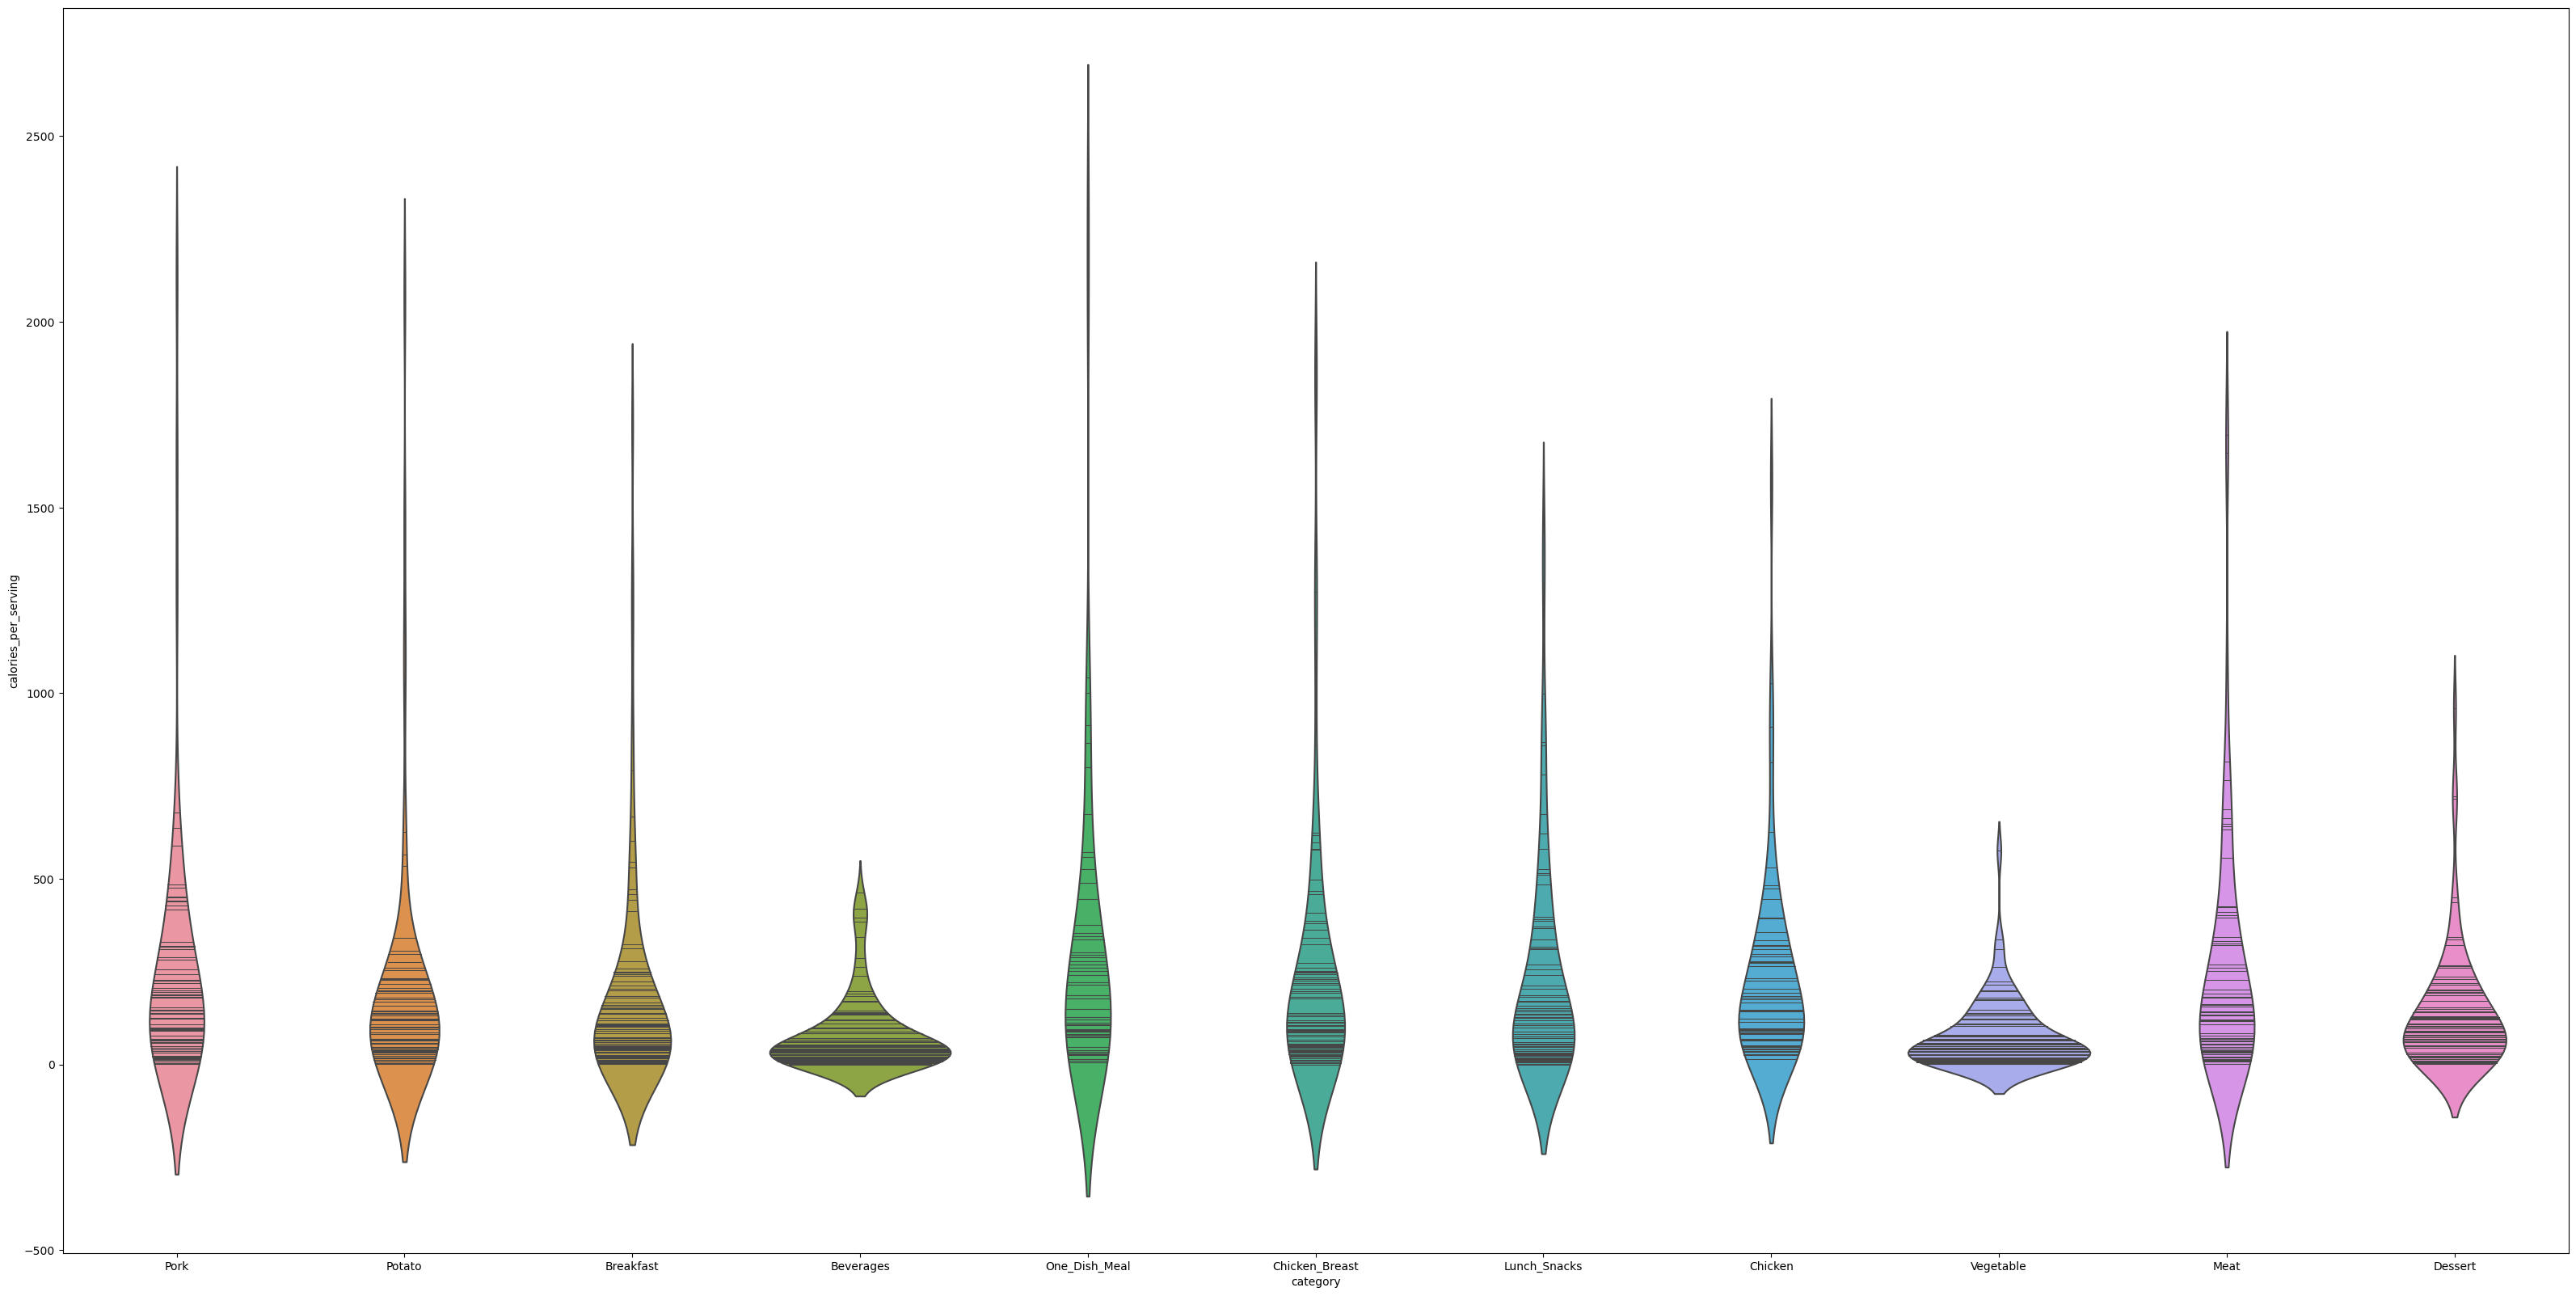

In [586]:
# Set the figure size
plt.figure(figsize=(40, 20))

# Create violin plots for column 'sugar' across different categories
sns.violinplot(data=qc_recipe_df, x="category", y="calories_per_serving", inner="stick")

# Show the plot
plt.show()

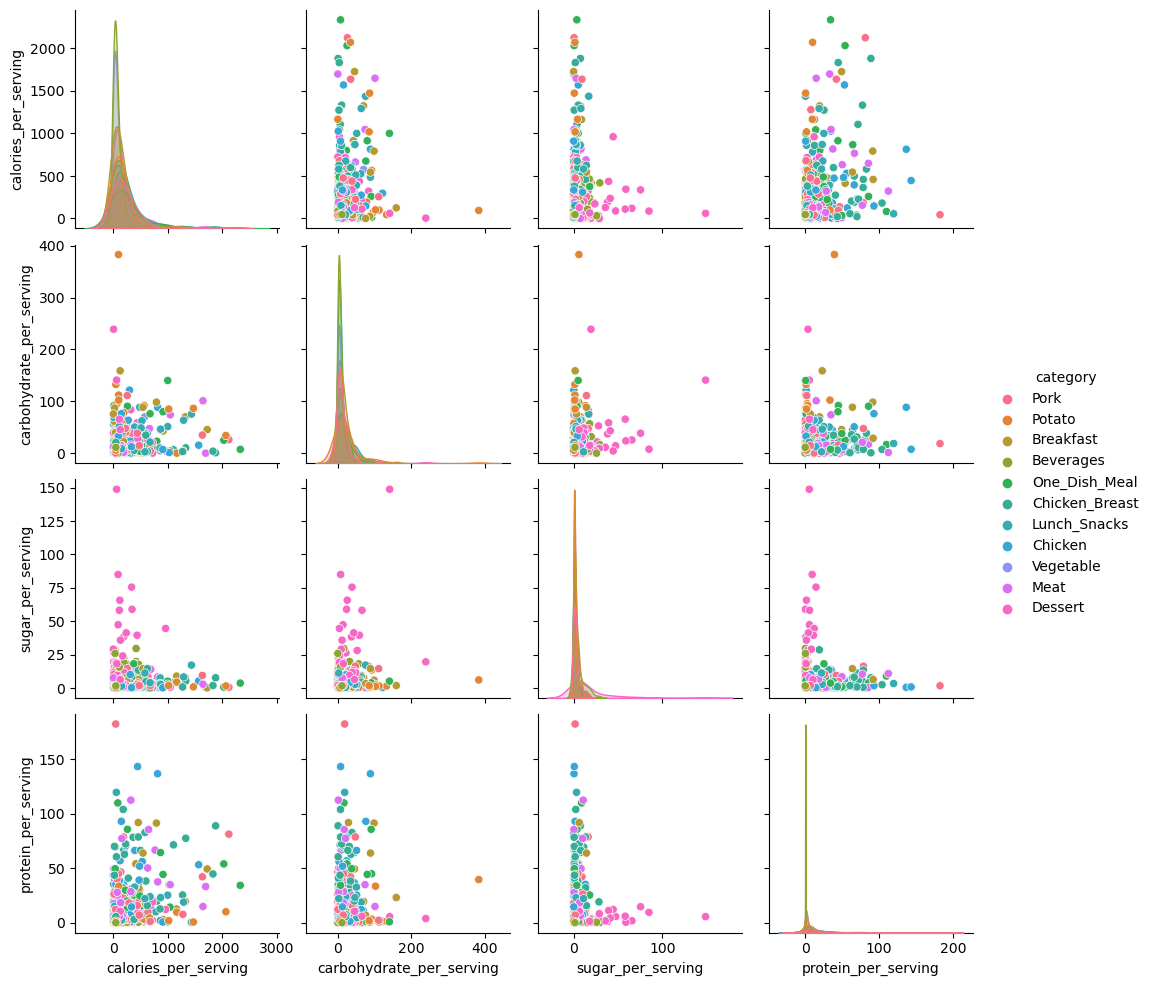

In [587]:
sns.pairplot(data=qc_recipe_df, vars=["calories_per_serving","carbohydrate_per_serving","sugar_per_serving","protein_per_serving"], hue="category")

### It looks like there are some outliers within some category. Let's dive deeper into this

In [588]:
qc_recipe_df['protein_per_serving'].describe()

count   895.00
mean     10.45
std      18.92
min       0.00
25%       0.98
50%       3.34
75%      11.12
max     182.63
Name: protein_per_serving, dtype: float64

In [589]:
qc_recipe_df['calories_per_serving'].describe()

count     895.00
mean      191.21
std       290.15
min         0.07
25%        33.69
50%        93.57
75%       225.24
max     2,332.32
Name: calories_per_serving, dtype: float64

In [590]:
qc_recipe_df['sugar_per_serving'].describe()

count   895.00
mean      3.83
std       8.74
min       0.00
25%       0.54
50%       1.40
75%       3.77
max     148.75
Name: sugar_per_serving, dtype: float64

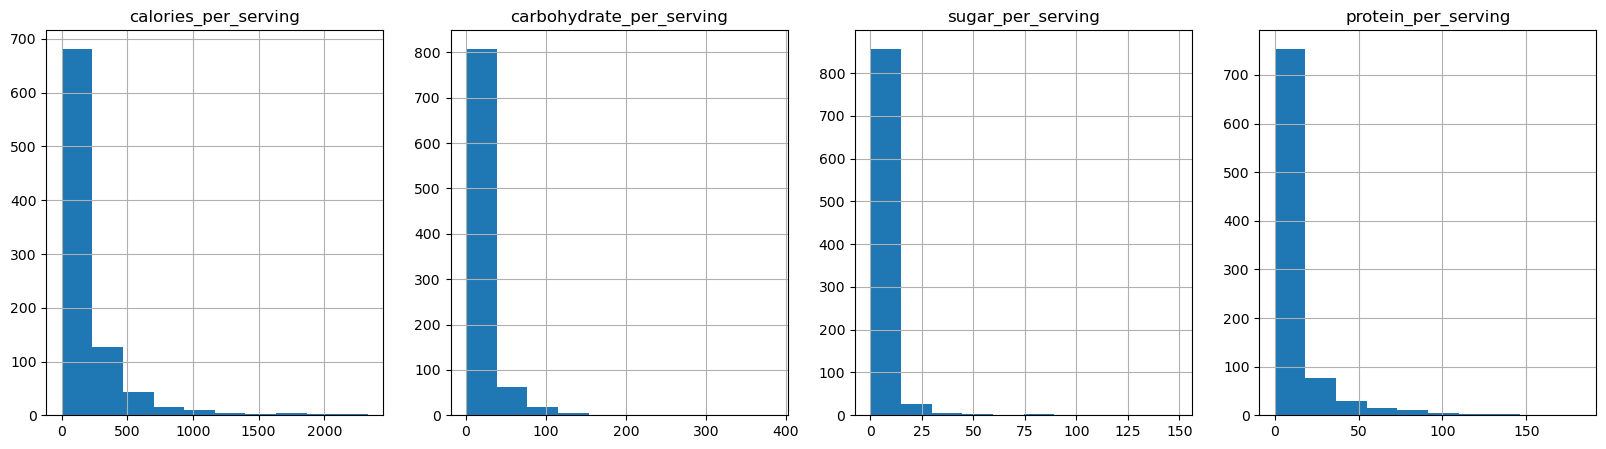

In [591]:
# create the subplots
fig, axs = plt.subplots(1, 4, figsize=(20,5))

# plot the histograms
qc_recipe_df["calories_per_serving"].hist(ax=axs[0])
qc_recipe_df["carbohydrate_per_serving"].hist(ax=axs[1])
qc_recipe_df["sugar_per_serving"].hist(ax=axs[2])
qc_recipe_df["protein_per_serving"].hist(ax=axs[3])

# Add titles to the subplots
axs[0].set_title("calories_per_serving")
axs[1].set_title("carbohydrate_per_serving")
axs[2].set_title("sugar_per_serving")
axs[3].set_title("protein_per_serving")

plt.show()

<Figure size 2000x500 with 0 Axes>

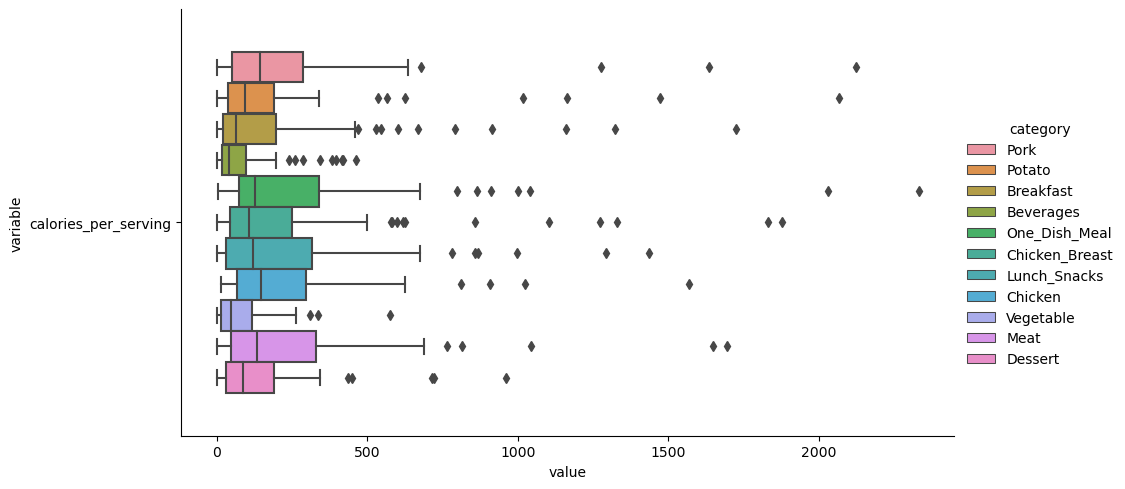

In [592]:
import seaborn as sns

# Use melt to reshape the DataFrame so that it has a single column for the values and a separate column for the variable
melted_df = qc_recipe_df.melt(id_vars=['category','servings'], value_vars=['calories_per_serving'], value_name='value', var_name='variable')

# Create a new figure with a specific size
plt.figure(figsize=(20,5))

# Use catplot to create boxplots for the columns 'calories_per_serving', 'carbohydrate_per_serving', 'sugar_per_serving', 'protein_per_serving'
sns.catplot(data=melted_df, x='value', y='variable', hue='category', kind='box', aspect=2)

# Show the plot
plt.show()


<Figure size 2000x500 with 0 Axes>

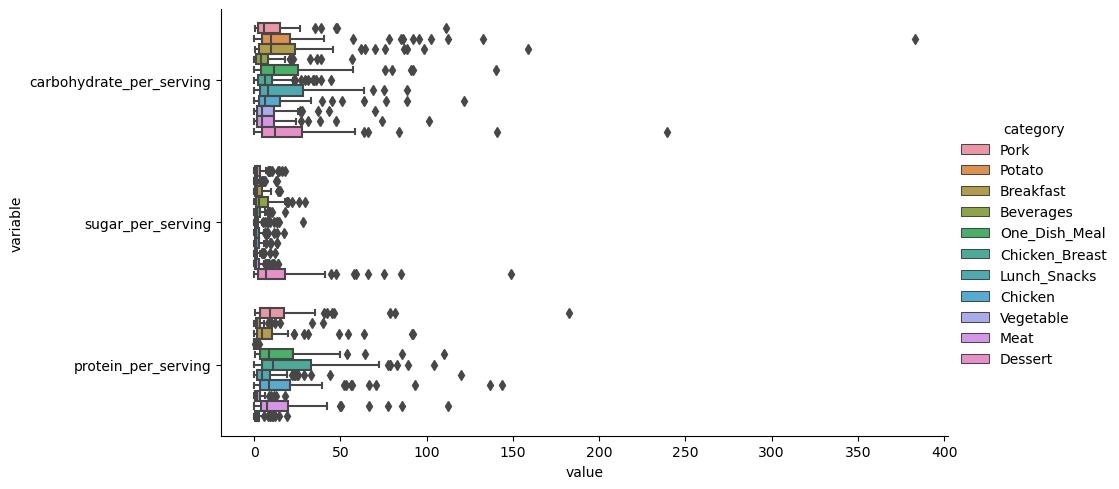

In [593]:
# Use melt to reshape the DataFrame so that it has a single column for the values and a separate column for the variable
melted_df2 = qc_recipe_df.melt(id_vars=['category','servings'], value_vars=['carbohydrate_per_serving','sugar_per_serving','protein_per_serving'], value_name='value', var_name='variable')

# Create a new figure with a specific size
plt.figure(figsize=(20,5))

# Use catplot to create boxplots for the columns 'calories_per_serving', 'carbohydrate_per_serving', 'sugar_per_serving', 'protein_per_serving'
sns.catplot(data=melted_df2, x='value', y='variable', hue='category', kind='box', aspect=2)

# Show the plot
plt.show()


### Let's identify those outliers 

In [594]:
def id_outlier(food_spec,qa1,qa3):
    # Calculate the interquartile range (IQR) of the 'calories' column
    q1, q3 = qc_recipe_df[food_spec].quantile([qa1,qa3])
    iqr = q3 - q1
    
    # Identify the outliers using the IQR and the lower and upper bounds.
    lower_bound = 0 #q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = qc_recipe_df[(qc_recipe_df[food_spec] < lower_bound) | (qc_recipe_df[food_spec] > upper_bound)]

    return outliers


In [595]:
id_outlier('calories_per_serving',0.5,0.95)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving
17,18,"1,695.82",0.10,0.39,33.17,Meat,1,1,"1,695.82",0.10,0.39,33.17
49,50,"1,724.25",45.52,0.07,49.37,Breakfast,1,1,"1,724.25",45.52,0.07,49.37
55,56,"2,122.24",25.99,0.52,81.37,Pork,1,1,"2,122.24",25.99,0.52,81.37
147,148,"1,568.00",15.49,5.23,53.23,Chicken,1,0,"1,568.00",15.49,5.23,53.23
292,293,"1,878.82",0.80,7.60,89.01,Chicken_Breast,1,1,"1,878.82",0.80,7.60,89.01
418,419,"1,830.28",3.92,1.83,44.74,Chicken_Breast,1,1,"1,830.28",3.92,1.83,44.74
428,429,"1,646.83",101.11,2.77,14.87,Meat,1,1,"1,646.83",101.11,2.77,14.87
566,567,"1,635.46",35.00,9.39,42.13,Pork,1,0,"1,635.46",35.00,9.39,42.13
636,637,"2,029.33",25.08,0.61,54.00,One_Dish_Meal,1,1,"2,029.33",25.08,0.61,54.00
781,782,"2,068.07",34.23,1.46,10.02,Potato,1,1,"2,068.07",34.23,1.46,10.02


In [596]:
id_outlier('protein_per_serving',0.5,0.95)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving
29,30,164.76,33.58,17.87,220.14,One_Dish_Meal,2,1,82.38,16.79,8.94,110.07
63,64,813.08,88.55,0.47,136.89,Chicken,1,1,813.08,88.55,0.47,136.89
342,343,111.10,37.55,6.60,239.57,Lunch_Snacks,2,0,55.55,18.77,3.30,119.78
638,639,321.95,1.41,10.76,112.64,Meat,1,1,321.95,1.41,10.76,112.64
695,696,891.11,15.20,1.50,286.97,Chicken,2,0,445.56,7.60,0.75,143.49
782,783,44.15,18.62,1.65,182.63,Pork,1,1,44.15,18.62,1.65,182.63


In [597]:
id_outlier('sugar_per_serving',0.5,0.95)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving
59,60,384.93,74.38,76.53,2.17,Dessert,2,0,192.47,37.19,38.27,1.08
96,97,88.57,14.31,47.32,5.67,Dessert,1,1,88.57,14.31,47.32,5.67
133,134,959.51,4.40,44.54,12.12,Dessert,1,0,959.51,4.40,44.54,12.12
271,272,435.94,58.65,39.46,11.18,Dessert,1,1,435.94,58.65,39.46,11.18
290,291,239.90,51.13,131.39,3.38,Dessert,2,1,119.95,25.57,65.69,1.69
378,379,235.91,43.20,41.24,4.27,Dessert,1,1,235.91,43.20,41.24,4.27
496,497,260.15,23.07,71.52,3.22,Dessert,2,1,130.07,11.54,35.76,1.61
540,541,60.62,140.98,148.75,5.53,Dessert,1,0,60.62,140.98,148.75,5.53
592,593,87.04,7.73,84.96,9.45,Dessert,1,1,87.04,7.73,84.96,9.45
668,669,343.96,23.79,58.88,0.41,Dessert,1,1,343.96,23.79,58.88,0.41


In [598]:
id_outlier('carbohydrate_per_serving',0.5,0.95)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving
167,168,4.41,239.06,19.54,3.76,Dessert,1,1,4.41,239.06,19.54,3.76
227,228,124.79,158.92,1.76,23.07,Breakfast,1,1,124.79,158.92,1.76,23.07
349,350,94.27,383.06,5.98,39.61,Potato,1,1,94.27,383.06,5.98,39.61
450,451,182.76,530.42,5.80,5.01,Potato,4,1,45.69,132.60,1.45,1.25
540,541,60.62,140.98,148.75,5.53,Dessert,1,0,60.62,140.98,148.75,5.53
717,718,999.59,140.22,5.08,0.76,One_Dish_Meal,1,1,999.59,140.22,5.08,0.76


##### The value of protein > 150, sugar >100 , carb > 200 seems really extreme. We will remove them 

In [599]:
outliers = qc_recipe_df[(qc_recipe_df['carbohydrate_per_serving'] > 200) | (qc_recipe_df['sugar_per_serving'] > 100) | (qc_recipe_df['protein_per_serving'] > 150)]

In [600]:
outliers

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving
167,168,4.41,239.06,19.54,3.76,Dessert,1,1,4.41,239.06,19.54,3.76
349,350,94.27,383.06,5.98,39.61,Potato,1,1,94.27,383.06,5.98,39.61
540,541,60.62,140.98,148.75,5.53,Dessert,1,0,60.62,140.98,148.75,5.53
782,783,44.15,18.62,1.65,182.63,Pork,1,1,44.15,18.62,1.65,182.63


In [601]:
# Remove the subset dataframe 'outliers' from the original dataset
qc_recipe_df = pd.concat([qc_recipe_df, outliers]).drop_duplicates(keep=False)

<Figure size 2000x500 with 0 Axes>

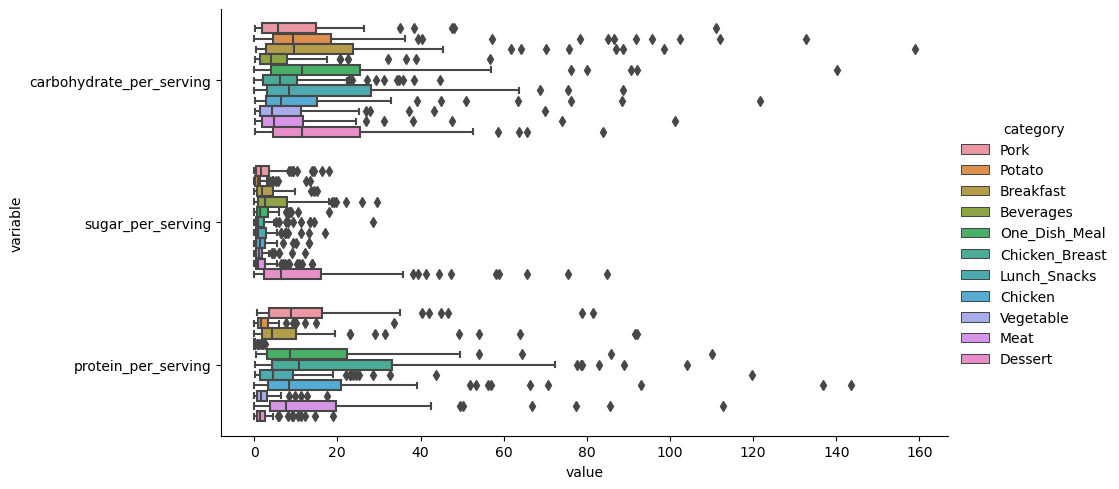

In [602]:
# Use melt to reshape the DataFrame so that it has a single column for the values and a separate column for the variable
melted_df2 = qc_recipe_df.melt(id_vars=['category','servings'], value_vars=['carbohydrate_per_serving','sugar_per_serving','protein_per_serving'], value_name='value', var_name='variable')

# Create a new figure with a specific size
plt.figure(figsize=(20,5))

# Use catplot to create boxplots for the columns 'calories_per_serving', 'carbohydrate_per_serving', 'sugar_per_serving', 'protein_per_serving'
sns.catplot(data=melted_df2, x='value', y='variable', hue='category', kind='box', aspect=2)

# Show the plot
plt.show()

### Let's now deal with the non-data value we have in the dataframe, by using the average of the food specs ('carbohydrate_per_serving','sugar_per_serving','protein_per_serving') per category 

In [603]:
# group data by category
grouped_data = qc_recipe_df.groupby('category')

# calculate median of food specs per category
median_carbohydrate = grouped_data['carbohydrate_per_serving'].median()
median_sugar = grouped_data['sugar_per_serving'].median()
median_protein = grouped_data['protein_per_serving'].median()

# fill non-data values in original dataframe with calculated median, as each distribution of macro nutrient is right-skewed
qc_recipe_df['carbohydrate_per_serving'] = qc_recipe_df['carbohydrate_per_serving'].fillna(qc_recipe_df.groupby('category')['carbohydrate_per_serving'].transform('median'))
qc_recipe_df['sugar_per_serving'] = qc_recipe_df['sugar_per_serving'].fillna(qc_recipe_df.groupby('category')['sugar_per_serving'].transform('median'))
qc_recipe_df['protein_per_serving'] = qc_recipe_df['protein_per_serving'].fillna(qc_recipe_df.groupby('category')['protein_per_serving'].transform('median'))
qc_recipe_df['calories_per_serving'] = qc_recipe_df['calories_per_serving'].fillna(qc_recipe_df.groupby('category')['calories_per_serving'].transform('median'))


<AxesSubplot: >

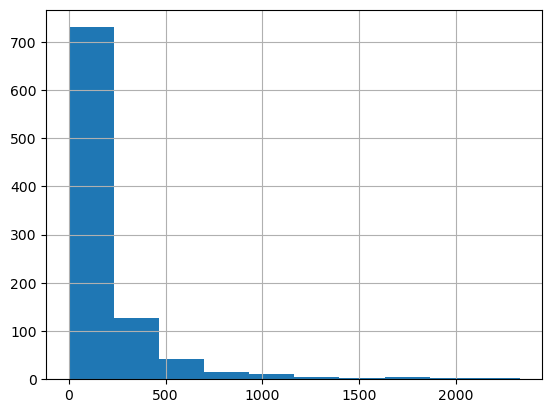

In [604]:
qc_recipe_df['calories_per_serving'].hist()

In [605]:
qc_recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 946
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   recipe                    943 non-null    int64  
 1   calories                  891 non-null    float64
 2   carbohydrate              891 non-null    float64
 3   sugar                     891 non-null    float64
 4   protein                   891 non-null    float64
 5   category                  943 non-null    object 
 6   servings                  943 non-null    int64  
 7   high_traffic              943 non-null    int64  
 8   calories_per_serving      943 non-null    float64
 9   carbohydrate_per_serving  943 non-null    float64
 10  sugar_per_serving         943 non-null    float64
 11  protein_per_serving       943 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 95.8+ KB


In [606]:
qc_recipe_df['high_traffic'].value_counts()

1    571
0    372
Name: high_traffic, dtype: int64

## EXploratory Data Analysis 
--- 

In [607]:
EDA_recipe_df = qc_recipe_df.drop(columns=["sugar", "calories", "protein", "carbohydrate"])
EDA_recipe_df = EDA_recipe_df.set_index("recipe")
EDA_recipe_df.index.name = "recipe_id"



### Calculating Fat amount in g, and macro-nutrient %

In [608]:
# we can use the formula : Fat (g) = (Total Calories - (Protein (g) * 4 + Carbohydrates (g) * 4 + Sugar (g) * 4)) / 9
# approximation from source: https://www.livestrong.com/article/81042-calculate-percentage-calories-fat-carbohydrate/
# ‌Carbohydrates:‌ 4 calories per gram
#  Fat:‌ 9 calories per gram
#  Protein:‌ 4 calories per gram
#  average daily intake = 1,600 calories per day per person

EDA_recipe_df['fat_per_serving'] = (EDA_recipe_df['calories_per_serving'] - ( EDA_recipe_df['protein_per_serving']*4 + EDA_recipe_df['sugar_per_serving']*4) )/9
EDA_recipe_df['fat_per_serving'] = EDA_recipe_df['fat_per_serving'].clip(lower=0)


<AxesSubplot: >

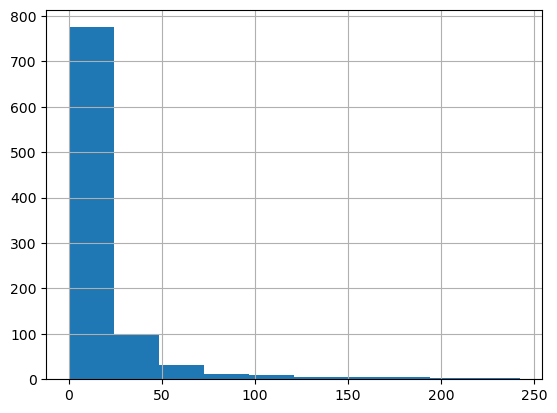

In [609]:
EDA_recipe_df['fat_per_serving'].hist()

In [610]:
EDA_recipe_df['fat_per_serving'].describe()

count   943.00
mean     16.07
std      28.44
min       0.00
25%       0.61
50%       7.03
75%      18.85
max     242.28
Name: fat_per_serving, dtype: float64

In [611]:
# Now let's calculate the percentengages of macro nurients
EDA_recipe_df['weight_per_serving'] = EDA_recipe_df['fat_per_serving'] + EDA_recipe_df['protein_per_serving'] + EDA_recipe_df['carbohydrate_per_serving']+ EDA_recipe_df['sugar_per_serving']
EDA_recipe_df['carb_%'] = EDA_recipe_df['carbohydrate_per_serving'] / EDA_recipe_df['weight_per_serving']
EDA_recipe_df['protein_%'] = EDA_recipe_df['protein_per_serving'] / EDA_recipe_df['weight_per_serving']
EDA_recipe_df['fat_%'] = EDA_recipe_df['fat_per_serving'] / EDA_recipe_df['weight_per_serving']
EDA_recipe_df['daily_intake_%'] = EDA_recipe_df['calories_per_serving'] / 1600

In [612]:
EDA_recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 947
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   category                  943 non-null    object 
 1   servings                  943 non-null    int64  
 2   high_traffic              943 non-null    int64  
 3   calories_per_serving      943 non-null    float64
 4   carbohydrate_per_serving  943 non-null    float64
 5   sugar_per_serving         943 non-null    float64
 6   protein_per_serving       943 non-null    float64
 7   fat_per_serving           943 non-null    float64
 8   weight_per_serving        943 non-null    float64
 9   carb_%                    943 non-null    float64
 10  protein_%                 943 non-null    float64
 11  fat_%                     943 non-null    float64
 12  daily_intake_%            943 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 103.1+ KB


In [613]:
EDA_recipe_df.describe()

,servings,high_traffic,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving,fat_per_serving,weight_per_serving,carb_%,protein_%,fat_%,daily_intake_%
count,943.00,943.00,943.00,943.00,943.00,943.00,943.00,943.00,943.00,943.00,943.00,943.00
mean,3.49,0.61,187.69,13.73,3.55,10.00,16.07,43.35,0.33,0.22,0.33,0.12
std,1.73,0.49,283.11,19.39,7.09,17.57,28.44,46.82,0.24,0.23,0.28,0.18
min,1.00,0.00,0.07,0.01,0.00,0.00,0.00,1.24,0.00,0.00,0.00,0.00
25%,2.00,0.00,35.75,2.67,0.59,1.11,0.61,15.40,0.13,0.05,0.04,0.02
50%,4.00,1.00,97.08,6.83,1.36,3.46,7.03,26.92,0.29,0.14,0.30,0.06
75%,4.00,1.00,213.70,15.48,3.50,10.17,18.85,51.33,0.50,0.32,0.55,0.13
max,6.00,1.00,"2,332.32",158.92,84.96,143.49,242.28,307.29,0.95,0.97,0.98,1.46


### Clustering in Macro Nutrient Categories
---

In [614]:
from sklearn.cluster import DBSCAN, KMeans

data = EDA_recipe_df[["carb_%", "protein_%", "fat_%"]].values

# Initialize the KMeans model with 6 clusters
kmeans = KMeans(n_clusters=5)

# Fit the model to the data
kmeans.fit(data)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels as a new column in the DataFrame
EDA_recipe_df["cluster"] = labels

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [615]:
import plotly.express as px

fig = px.scatter_ternary(EDA_recipe_df, a="carb_%", b="protein_%", c="fat_%",color='cluster',hover_name='cluster')
fig.update_layout(
    title="Ternary Plot of Carbohydrates, Protein, and Fat in Recipes",
    font=dict(
        size=12,
        color="#7f7f7f"
    ),
    scene=dict(
        xaxis_title="Carbohydrates (%)",
        yaxis_title="Protein (%)",
        zaxis_title="Fat (%)"
    )
)
fig.show()

In [616]:
# Group the DataFrame by the cluster labels and calculate the mean for each column
cluster_means = EDA_recipe_df[["carb_%", "protein_%", "fat_%","cluster"]].groupby("cluster").mean().reset_index()

print(cluster_means)

   cluster  carb_%  protein_%  fat_%
0        0    0.11       0.11   0.72
1        1    0.19       0.31   0.30
2        2    0.21       0.68   0.03
3        3    0.65       0.13   0.08
4        4    0.40       0.08   0.43


### function for encoding dummies
---

In [617]:

def dummies (df:pd.DataFrame,cols,prefix):
    # Select the categorical columns to be encoded
    categorical_cols = [cols]
    
    # Create dummy variables for each category
    df_dummies = pd.get_dummies(df[categorical_cols], prefix)
    
    # Drop the original categorical columns
    df.drop(categorical_cols, axis=1, inplace=True)
    
    # Concatenate the original dataframe with the dummy encoded dataframe
    df = pd.concat([df, df_dummies], axis=1)

    return df

In [618]:
EDA_recipe_df = dummies (EDA_recipe_df,'category', 'meal')

In [619]:
EDA_recipe_df.columns

Index(['servings', 'high_traffic', 'calories_per_serving',
       'carbohydrate_per_serving', 'sugar_per_serving', 'protein_per_serving',
       'fat_per_serving', 'weight_per_serving', 'carb_%', 'protein_%', 'fat_%',
       'daily_intake_%', 'cluster', 'meal_Beverages', 'meal_Breakfast',
       'meal_Chicken', 'meal_Chicken_Breast', 'meal_Dessert',
       'meal_Lunch_Snacks', 'meal_Meat', 'meal_One_Dish_Meal', 'meal_Pork',
       'meal_Potato', 'meal_Vegetable'],
      dtype='object')

In [620]:
EDA_recipe_df['cluster'] = EDA_recipe_df['cluster'].astype(str)

In [621]:
EDA_recipe_df.dtypes

servings                      int64
high_traffic                  int64
calories_per_serving        float64
carbohydrate_per_serving    float64
sugar_per_serving           float64
protein_per_serving         float64
fat_per_serving             float64
weight_per_serving          float64
carb_%                      float64
protein_%                   float64
fat_%                       float64
daily_intake_%              float64
cluster                      object
meal_Beverages                uint8
meal_Breakfast                uint8
meal_Chicken                  uint8
meal_Chicken_Breast           uint8
meal_Dessert                  uint8
meal_Lunch_Snacks             uint8
meal_Meat                     uint8
meal_One_Dish_Meal            uint8
meal_Pork                     uint8
meal_Potato                   uint8
meal_Vegetable                uint8
dtype: object

In [622]:
EDA_recipe_df = dummies (EDA_recipe_df,'cluster', 'type')

In [623]:
EDA_recipe_df.columns

Index(['servings', 'high_traffic', 'calories_per_serving',
       'carbohydrate_per_serving', 'sugar_per_serving', 'protein_per_serving',
       'fat_per_serving', 'weight_per_serving', 'carb_%', 'protein_%', 'fat_%',
       'daily_intake_%', 'meal_Beverages', 'meal_Breakfast', 'meal_Chicken',
       'meal_Chicken_Breast', 'meal_Dessert', 'meal_Lunch_Snacks', 'meal_Meat',
       'meal_One_Dish_Meal', 'meal_Pork', 'meal_Potato', 'meal_Vegetable',
       'type_0', 'type_1', 'type_2', 'type_3', 'type_4'],
      dtype='object')

### Dealing with Class Imbalance
We will use oversampling the class 0 (low traffic) with the random duplication of observations with low traffic , as we don't want to remove observations of High Traffic (what we want to predit)

In [624]:
# get the indices of the minority class
minority_indices = EDA_recipe_df[EDA_recipe_df['high_traffic'] == 0].index

# get the indices of the majority class
majority_indices = EDA_recipe_df[EDA_recipe_df['high_traffic'] == 1].index

# randomly select equal number of indices from the minority class as the majority class
random_minority_indices = np.random.choice(minority_indices, len(majority_indices), replace=True)

# combine the indices of both classes
balanced_indices = np.concatenate([majority_indices, random_minority_indices])

# balance the classes using the indices
BAL_recipe_df = EDA_recipe_df.loc[balanced_indices]

In [625]:
BAL_recipe_df['high_traffic'].value_counts()

1    571
0    571
Name: high_traffic, dtype: int64

---

### Generating the Features and Target Sets

#### Create the features set

In [626]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = BAL_recipe_df.drop(columns=["high_traffic"])
#X = X.drop(columns=["cluster"])

# Display sample data
display(X.head())
display(X.tail())

,servings,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving,fat_per_serving,weight_per_serving,carb_%,protein_%,fat_%,...,meal_Meat,meal_One_Dish_Meal,meal_Pork,meal_Potato,meal_Vegetable,type_0,type_1,type_2,type_3,type_4
recipe_id,,,,,,,,,,,,,,,,,,,,,
1,6,145.23,5.69,1.57,8.95,11.46,27.67,0.21,0.32,0.41,...,0,0,1,0,0,0,1,0,0,0
2,4,8.87,9.64,0.17,0.23,0.81,10.84,0.89,0.02,0.07,...,0,0,0,1,0,0,0,0,1,0
4,4,24.26,7.64,9.66,0.01,0.00,17.30,0.44,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
6,2,345.57,1.73,0.82,26.96,26.05,55.57,0.03,0.49,0.47,...,0,1,0,0,0,0,1,0,0,0
9,6,89.75,0.63,0.56,0.63,9.44,11.27,0.06,0.06,0.84,...,0,0,1,0,0,1,0,0,0,0


,servings,calories_per_serving,carbohydrate_per_serving,sugar_per_serving,protein_per_serving,fat_per_serving,weight_per_serving,carb_%,protein_%,fat_%,...,meal_Meat,meal_One_Dish_Meal,meal_Pork,meal_Potato,meal_Vegetable,type_0,type_1,type_2,type_3,type_4
recipe_id,,,,,,,,,,,,,,,,,,,,,
886,4,41.71,39.93,0.70,5.37,1.94,47.94,0.83,0.11,0.04,...,0,0,0,0,0,0,0,0,1,0
881,4,70.64,2.47,0.47,0.04,7.62,10.60,0.23,0.00,0.72,...,0,0,0,0,0,1,0,0,0,0
404,4,31.74,4.78,4.54,0.04,1.49,10.85,0.44,0.00,0.14,...,0,0,0,0,0,0,0,0,1,0
23,4,20.68,0.79,1.99,6.51,0.00,9.29,0.09,0.70,0.00,...,0,0,0,0,0,0,0,1,0,0
220,1,"1,330.48",10.34,5.22,77.57,111.04,204.17,0.05,0.38,0.54,...,0,0,0,0,0,0,1,0,0,0


#### Create the target set

In [627]:
# Copy the new signal column to a new Series called y.
y = BAL_recipe_df["high_traffic"].copy()

### keep only the 15 features with the lowest correlation:

---

In [628]:

# calculate the correlation matrix
corr_matrix = X.corr().abs()

# get the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# get the index of the features with the lowest correlation
to_keep = [column for column in upper.columns if any(upper[column] < 0.8)]

# keep only the features with the lowest correlation
X = X[to_keep]


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [629]:
X.columns

Index(['calories_per_serving', 'carbohydrate_per_serving', 'sugar_per_serving',
       'protein_per_serving', 'fat_per_serving', 'weight_per_serving',
       'carb_%', 'protein_%', 'fat_%', 'daily_intake_%', 'meal_Beverages',
       'meal_Breakfast', 'meal_Chicken', 'meal_Chicken_Breast', 'meal_Dessert',
       'meal_Lunch_Snacks', 'meal_Meat', 'meal_One_Dish_Meal', 'meal_Pork',
       'meal_Potato', 'meal_Vegetable', 'type_0', 'type_1', 'type_2', 'type_3',
       'type_4'],
      dtype='object')

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training and Testing Datasets

In [630]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)


#### Standardizing the Data

In [631]:
# Imports
from sklearn.preprocessing import StandardScaler

In [632]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [633]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

In [634]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

In [635]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       382
           1       0.79      0.79      0.79       360

    accuracy                           0.79       742
   macro avg       0.79      0.79      0.79       742
weighted avg       0.79      0.79      0.79       742



In [636]:
test_predictions = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions, average='micro')

# Print the results
print(f'Test accuracy: {accuracy:.2f}')
print(f'Test F1 score: {f1:.2f}')

Test accuracy: 0.76
Test F1 score: 0.76


In [637]:
# Evaluate the model using a classification report
testing_report = classification_report(y_test, test_predictions)
print(training_report)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       382
           1       0.79      0.79      0.79       360

    accuracy                           0.79       742
   macro avg       0.79      0.79      0.79       742
weighted avg       0.79      0.79      0.79       742



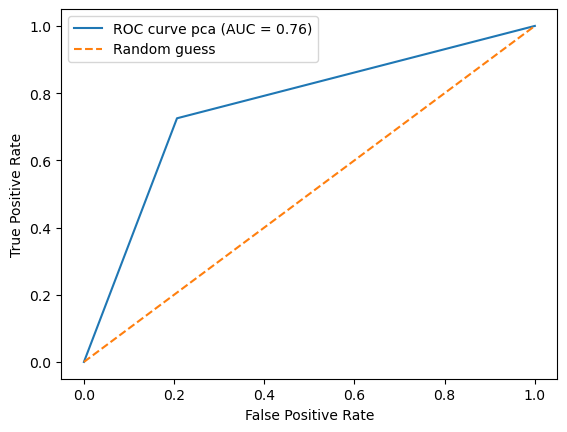

In [638]:
# display ROC_curve and claculate AUC
from sklearn.metrics import roc_curve, roc_auc_score

# calculate the true positive rate and false positive rate for different probability thresholds:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)

# Calculate the AUC 
auc = roc_auc_score(y_test, test_predictions )

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve pca (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


---

# Add a New Machine Learning Model

## Import the `RandomForest` model from scikit-learn.


In [639]:
# Import RandomForest from sklearn
from sklearn.ensemble import RandomForestClassifier

In [640]:
# Create an instance of the RandomForest model
rf_classifier = RandomForestClassifier()

## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `RandomForest` model.

In [641]:
# Fit the LogisticRegression model
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [642]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
rf_training_signal_predictions = rf_classifier.predict(X_train_scaled)

In [643]:
# Generate a classification report using the training data and the logistic regression model's predications
rf_training_report = classification_report(y_train, rf_training_signal_predictions)

# Review the classification report
print(rf_training_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       382
           1       0.99      1.00      0.99       360

    accuracy                           0.99       742
   macro avg       0.99      0.99      0.99       742
weighted avg       0.99      0.99      0.99       742



## Backtest the `RandomForestClassifier` model using the testing data to evaluate its performance.

In [644]:
# Use the trained model to predict the trading signals for the testing data.
rf_test_predictions = rf_classifier.predict(X_test_scaled)

In [645]:
# Generate a classification report using the testing data and the logistic regression model's predictions
rf_testing_report = classification_report(y_test, rf_test_predictions)

# Review the testing classification report
print(rf_testing_report)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       189
           1       0.83      0.79      0.81       211

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [646]:
# Calculate the accuracy and F1 score for the test data
accuracy = accuracy_score(y_test, rf_test_predictions)
f1 = f1_score(y_test, rf_test_predictions, average='micro')

# Print the results
print(f'Test accuracy: {accuracy:.2f}')
print(f'Test F1 score: {f1:.2f}')

Test accuracy: 0.80
Test F1 score: 0.80


# Part 2 - xgboost Classifier

---

### Incorporate the xgboost Machine Learning Into the Trading Strategy

In [647]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=6)

xgb_clf.fit(X_train_scaled, y_train)

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

# Calculate the accuracy and F1 score for the test data
accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb, average='micro')

# Print the results
print(f'Test accuracy: {accuracy:.2f}')
print(f'Test F1 score: {f1:.2f}')

Test accuracy: 0.77
Test F1 score: 0.77


### Displaying ROC Curve

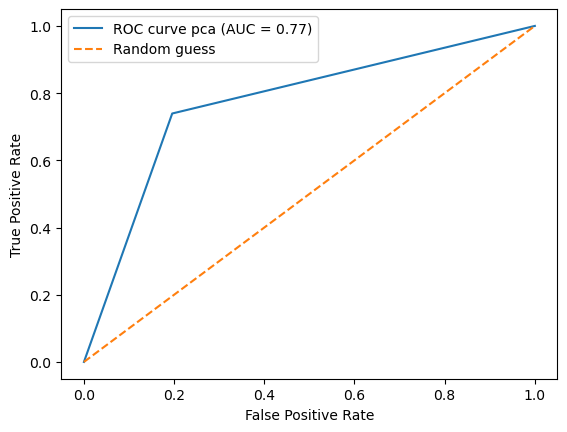

In [648]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

xgb_signal_predictions = xgb_clf.predict(X_test_scaled)

#Calculate ROC Curve
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_signal_predictions )

# Calculate the AUC 
xgb_auc = roc_auc_score(y_test, xgb_signal_predictions )

# Plot the ROC curve
plt.plot(xgb_fpr, xgb_tpr, label='ROC curve pca (AUC = {:.2f})'.format(xgb_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [649]:
# Generate a classification report using the training data predictions
xgb_training_predictions = xgb_clf.predict(X_train_scaled)
xgb_training_report = classification_report(y_train, xgb_training_predictions)

# Review the testing classification report
print(xgb_training_report)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       382
           1       0.89      0.88      0.88       360

    accuracy                           0.89       742
   macro avg       0.89      0.89      0.89       742
weighted avg       0.89      0.89      0.89       742



In [650]:
# Generate a classification report using the testing data and the pca model's predictions
xgb_testing_report = classification_report(y_test, xgb_signal_predictions)

# Review the testing classification report
print(xgb_testing_report)

              precision    recall  f1-score   support

           0       0.73      0.80      0.77       189
           1       0.81      0.74      0.77       211

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



### Introducting SHAP
--- 
from (https://www.dominodatalab.com/blog/shap-lime-python-libraries-part-2-using-shap-lime)

In [655]:
import shap 
import sklearn #for building models
import xgboost as xgb #for building models
import sklearn.ensemble #for building models
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do

# Random Forest
#rf = sklearn.ensemble.RandomForestRegressor()
# rf.fit(X_train, y_train)



ImportError: cannot import name '_open_binary' from 'sklearn.utils.fixes' (/Users/adriencaudron/miniforge3/envs/algotrading/lib/python3.8/site-packages/sklearn/utils/fixes.py)

In [ ]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_clf)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

# Tree on Random Forest explainer
explainerRF = shap.TreeExplainer(rf_classifier)
shap_values_RF_test = explainerRF.shap_values(X_test)
shap_values_RF_train = explainerRF.shap_values(X_train)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)

# Random Forest
df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)

In [ ]:
## setting up LIME 
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten() 
    # LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
    feature_names=X_train.columns.values.tolist(),
    class_names=['price'],
    categorical_features=categorical_features,
    verbose=True, mode='regression')

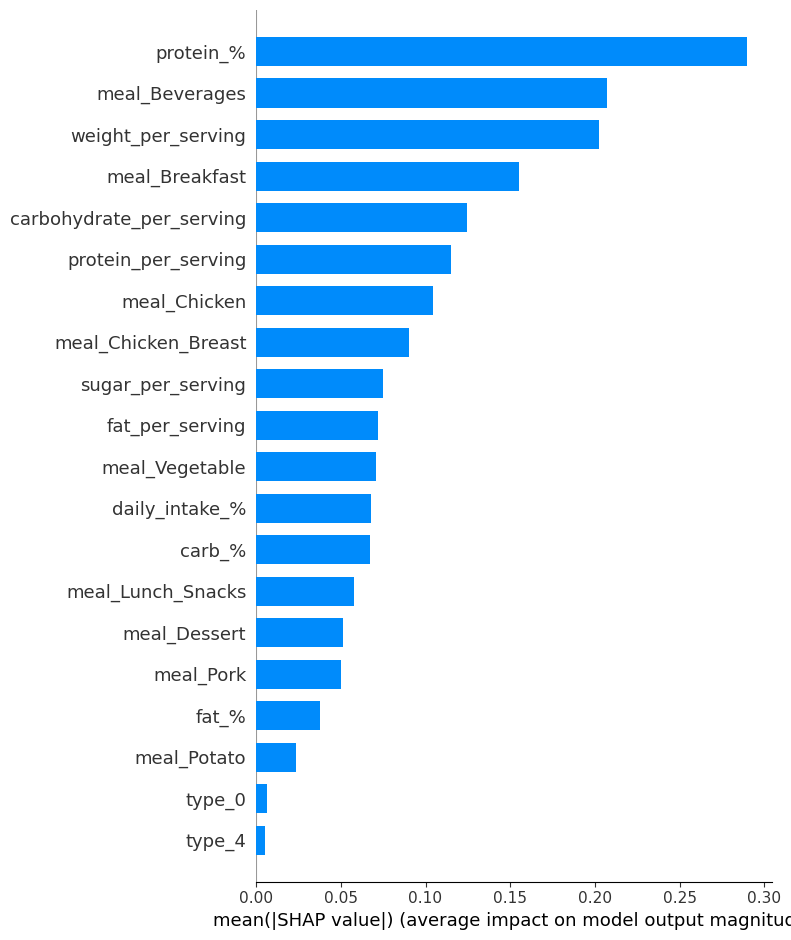

In [ ]:
shap.summary_plot(shap_values_XGB_test, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


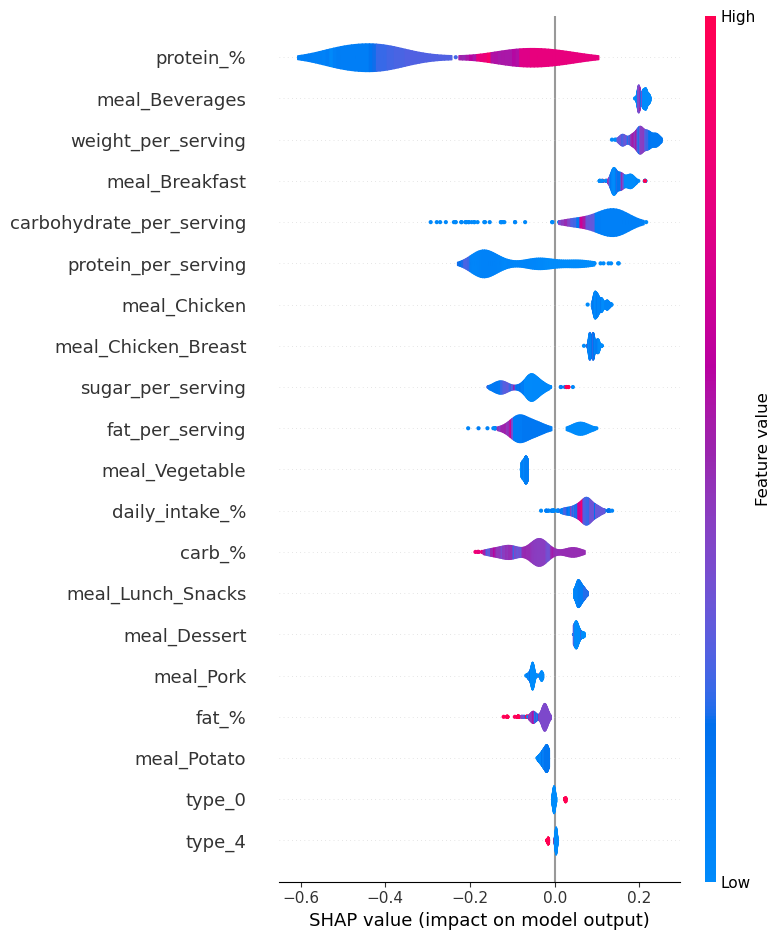

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values_XGB_test, X_test,plot_type='violin')

### Using a neural network NNT

In [ ]:
# Import the `Dropout` layer
from keras.layers import Dropout
# Import regularization functions
from keras.regularizers import l1, l2
from keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential

In [ ]:
# Build the Model
model = Sequential()
# number of feaatures to be used as input 
nb_input = len(X.columns)
# Add a dense layer
model.add(Dense(10, input_dim=nb_input, activation='relu'))
# Now add a dropout layer
model.add(Dropout(.2,input_shape=(10,)))
# Add another dense layer
model.add(Dense(6, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# Add the output layer to the model specifying the number of output neurons and activation function
model.add(Dense(units=1, activation="sigmoid"))

In [ ]:

# Compile the Sequential model
#model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Summarise the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                270       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 6)                 66        
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Add in validation loss to select the number of epochs
# Fit the model
number_of_epochs = 20
model.fit(X_train,y_train, 
                    epochs=number_of_epochs,
                    batch_size=10,
                    #validation_split=0.2,
                    shuffle=True)

Epoch 1/200


2023-01-30 15:27:52.850185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 2s 12ms/step - loss: 6.8044 - accuracy: 0.5067
Epoch 2/200
75/75 [==============================] - 1s 9ms/step - loss: 1.8733 - accuracy: 0.5404
Epoch 3/200
75/75 [==============================] - 1s 9ms/step - loss: 1.4987 - accuracy: 0.5377
Epoch 4/200
75/75 [==============================] - 1s 9ms/step - loss: 1.2872 - accuracy: 0.5094
Epoch 5/200
75/75 [==============================] - 1s 8ms/step - loss: 1.0700 - accuracy: 0.5472
Epoch 6/200
75/75 [==============================] - 1s 8ms/step - loss: 0.9979 - accuracy: 0.5539
Epoch 7/200
75/75 [==============================] - 1s 9ms/step - loss: 0.9388 - accuracy: 0.5472
Epoch 8/200
75/75 [==============================] - 1s 10ms/step - loss: 0.8779 - accuracy: 0.5553
Epoch 9/200
75/75 [==============================] - 1s 9ms/step - loss: 0.8704 - accuracy: 0.5458
Epoch 10/200
75/75 [==============================] - 1s 10ms/step - loss: 0.8099 - accuracy: 0.5714
Epoch 11/200
75/75

### Step 2: Evaluate the model using the test data to determine its loss and accuracy.

In [ ]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2023-01-30 15:30:03.278355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 - 0s - loss: 0.7190 - accuracy: 0.7650 - 291ms/epoch - 22ms/step
Loss: 0.7189862728118896, Accuracy: 0.7649999856948853


### ML Model selection
---

In [ ]:
### Choose the best ML model for our set : 
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianN

In [ ]:
def model_selection(X,Y):
    seed = 7
    models = []
    models.append(('LogisticRegression', LogisticRegression(random_state=seed)))
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    #models.append(('GaussianNB', GaussianNB()))
    models.append(('RandomForestClassifier', RandomForestClassifier()))
    models.append(('ExtraTreesClassifier',ExtraTreesClassifier(random_state=seed)))
    models.append(('AdaBoostClassifier',AdaBoostClassifier(DecisionTreeClassifier(random_state=seed),random_state=seed,learning_rate=0.1)))
    models.append(('SVM',svm.SVC(random_state=seed)))
    models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=seed)))
    models.append(('XGBoost', xgb.XGBClassifier(random_state=seed)))
    #models.append(('MLPClassifier',MLPClassifier(random_state=seed)))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    
    for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed) 
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg) 
    return results, names
 

In [ ]:
#model_selection(X,y)